## Goal:
Convert adudio to text ---> Model_1: classify ailments by severity (0 vs 1) ---> Model_2: classify by domain

### Steps
1. input audio files: 
    - source: https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent

2. transcribe them to text: Automatic Speech Recognition (ASR) [API]
    - Hidden Markov Model (HMM), deep neural network models are used to convert the audio into text.
    - possible tools: Google Cloud Speech-to-Text, Mozilla's DeepSpeech, or the Kaldi ASR toolkit
    - Google Cloud Speech-to-Text: https://codelabs.developers.google.com/codelabs/cloud-speech-text-python3#1


3. summarize the content
    - huggingface (summarization): https://huggingface.co/tasks/summarization
    - huggingface (classification): https://huggingface.co/tasks/audio-classification

4. sentiment analysis of the text 
    - NLTK sentiment analysis
    - classification models

### Tools
2. Google Cloud Speech-to-Text
3. NLP packages

## Step 1

In [354]:
# Installing dependencies

## converting audio to text
# pip install SpeechRecognition
# pip install tqdm

## extracting features from audio
# pip install pydub


# classification
# pip install cleantext



In [355]:
# converting audio to text
import speech_recognition as sr
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# visualizations
import seaborn as sns
import matplotlib.pyplot as pl

#regex
import re

# word frequency for classification
from nltk.corpus import stopwords
from collections import Counter


In [356]:
# List of functions usined in the code


def get_file_name(path):
    """Extract fil name from path. The input is a string."""
    pattern = r"/([^/]+)$"  # Regular expression pattern to match the file name at the end of the path
    match = re.search(pattern, path)
    if match:
        file_name = match.group(1)
        return file_name
    else:
        return None
    
    
def do_clean(text):
    """The string (text) is converted to lowercase, it is stripped, and the punctualization is removed."""
    return clean(text, lowercase=True, extra_spaces=False, punct=True)


In [357]:
# color palette for all figures (following 1177 color palette)
dark = "#c22e44ff"
light= "#fbeef0ff"

# STEP_1: convert audio to text
The folder downloaded from Kaggle contains 3 subfolders, named "test", "train" and "validate", 
with respectively 5895, 381 and 385 wav files. 

__Tool__: 
- recognize_google (https://github.com/Uberi/speech_recognition/blob/master/reference/library-reference.rst)
- tqdm (to estimate progress)


### Processing TRAIN folder

In [6]:
# This can be converted into a function to make the script lighter to read!!!


dir_path = "/Users/admin/Downloads/archive (3)/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/train/"
audio_files = os.listdir(dir_path)

# Create a recognizer object
r = sr.Recognizer()


#Testing 2 files
#audio_files = ["1249120_44142156_61923550.wav","1249120_44246595_76562955.wav"]

# including all files
audio_files = os.listdir(dir_path)



# Create empty lists to store text and filename
text_list = []
filename_list = []

# Process each audio file
for i in tqdm(range(len(audio_files)), desc="Processing"):
    
    audio_file = dir_path+audio_files[i]
    
    # Open the audio file
    with sr.AudioFile(audio_file) as source:
        # Read the audio data
        audio_data = r.record(source)

    # Convert speech to text
    text = r.recognize_google(audio_data, show_all = True )

    # Append text and filename to lists
    text_list.append(text)
    filename_list.append(audio_file)

Processing: 100%|█████████████████████████████| 381/381 [06:21<00:00,  1.00s/it]


In [7]:
# Create DataFrame
df_train = {"Text": text_list, "Filename": filename_list}
df_train = pd.DataFrame(df_train)

#### Extracting 'transcript' and 'confidence' value from Text column

In [19]:
# Initializing empty lists  ---> convert to function and use that instad!
text_clean_lst = []
confidence_level_lst = []

for i in range(len(df_train.Text)):
    
    if len(df_train.Text[i]) == 0:
        text_clean_lst.append(None)
        confidence_level_lst.append(None)
        
        
    else:
        input_sentence = list(enumerate(df_train.Text[i].items()))
        #clean text
        text_clean = input_sentence[0][1][1][0]['transcript']
        text_clean_lst.append(text_clean)
        #confidence levels
        confidence_level = input_sentence[0][1][1][0]['confidence']
        confidence_level_lst.append(confidence_level)

df_train['text_clean'] = text_clean_lst
df_train['confidence'] = confidence_level_lst

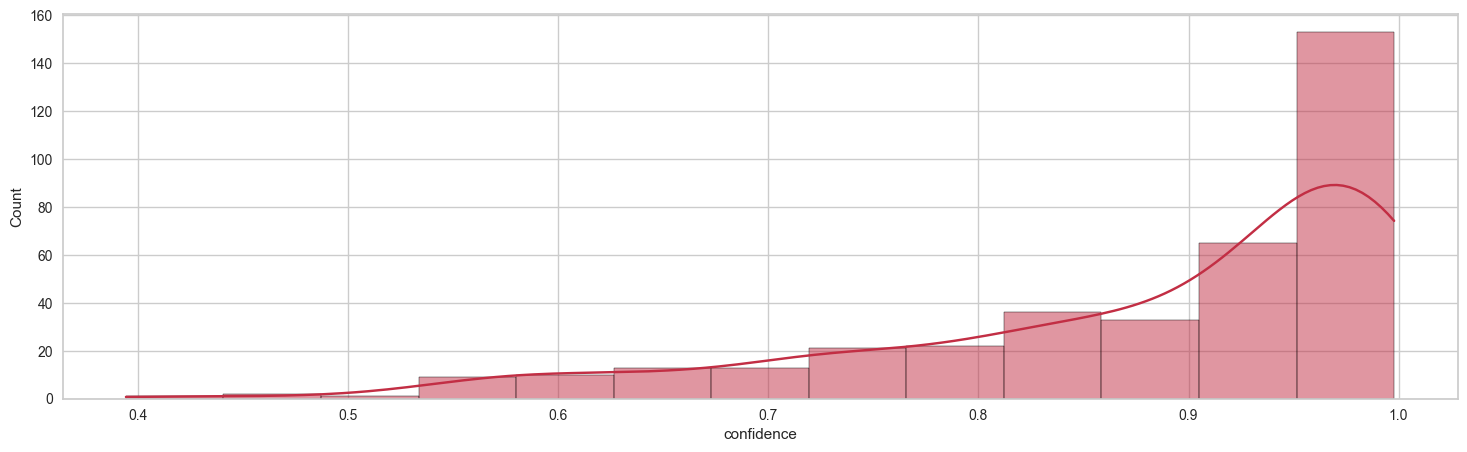

In [361]:
# Visualizing 'confidence' in a histogram
plt.figure(figsize=(18, 5))
sns.histplot(data = df_train, x='confidence', kde = True, color = dark)
plt.show()

#### Set confidence threshold to 0.5

In [22]:
# Using arbitrary cutoff at 0.5
df_train['keep'] = np.where(df_train['confidence'] <= 0.5, 'No', 'Yes')

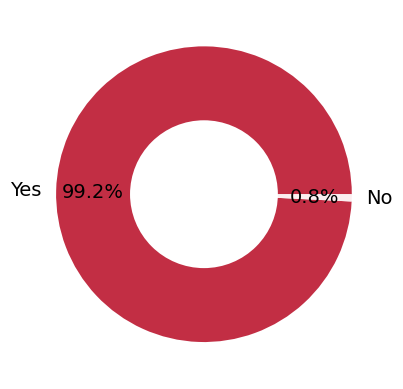

In [66]:
# Donut plot
label = list(pd.Series(df_train['keep']).value_counts().index)
count = list(pd.Series(df_train['keep']).value_counts().values)

colors = [dark, light]
#explode = (0.05, 0.05)
plt.pie(count, colors=colors, labels=label,
        autopct='%1.1f%%', pctdistance=0.75, textprops={'fontsize': 14})
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [96]:
# Clean Filename column

file_name_clean = []
for i in range(len(df_train)):
    
    path = df_train['Filename'][i]
    file_name = get_file_name(path)
    file_name_clean.append(file_name)

df_train['file_name_clean']=file_name_clean

#### Processing VALIDATE folder

In [16]:
dir_path = "/Users/admin/Downloads/archive (3)/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/validate/"
audio_files = os.listdir(dir_path)


# Create a recognizer object
r = sr.Recognizer()

#Testing 2 files
#audio_files = ["1249120_44142156_61923550.wav","1249120_44246595_76562955.wav"]

# including all files
audio_files = os.listdir(dir_path)

# Create empty lists to store text and filename
text_list = []
filename_list = []

# Process each audio file
for i in tqdm(range(len(audio_files)), desc="Processing"):
    
    audio_file = dir_path+audio_files[i]
    
    # Open the audio file
    with sr.AudioFile(audio_file) as source:
        # Read the audio data
        audio_data = r.record(source)

    # Convert speech to text
    text = r.recognize_google(audio_data, show_all = True )

    # Append text and filename to lists
    text_list.append(text)
    filename_list.append(audio_file)
    
    

Processing: 100%|█████████████████████████████| 385/385 [10:58<00:00,  1.71s/it]


In [17]:
# Create DataFrame
df_validate = {"Text": text_list, "Filename": filename_list}
df_validate = pd.DataFrame(data)

,Text,Filename
0,{'alternative': [{'transcript': 'when I'm too ...,/Users/admin/Downloads/archive (3)/medical spe...
1,{'alternative': [{'transcript': 'my body feels...,/Users/admin/Downloads/archive (3)/medical spe...
2,{'alternative': [{'transcript': 'I feel a grea...,/Users/admin/Downloads/archive (3)/medical spe...
3,{'alternative': [{'transcript': 'I walked it's...,/Users/admin/Downloads/archive (3)/medical spe...
4,{'alternative': [{'transcript': 'my neck has b...,/Users/admin/Downloads/archive (3)/medical spe...


In [72]:
# Clean Text column (keep 'transcript' and  'confidence' value) ---> use the function (once it is done) instaed
text_clean_lst = []
confidence_level_lst = []

for i in range(len(df_validate.Text)):
    
    if len(df_validate.Text[i]) == 0:
        text_clean_lst.append(None)
        confidence_level_lst.append(None)
        
        
    else:
        input_sentence = list(enumerate(df_validate.Text[i].items()))
        #clean text
        text_clean = input_sentence[0][1][1][0]['transcript']
        text_clean_lst.append(text_clean)
        #confidence levels
        confidence_level = input_sentence[0][1][1][0]['confidence']
        confidence_level_lst.append(confidence_level)

df_validate['text_clean'] = text_clean_lst
df_validate['confidence'] = confidence_level_lst

<Axes: xlabel='confidence', ylabel='Count'>

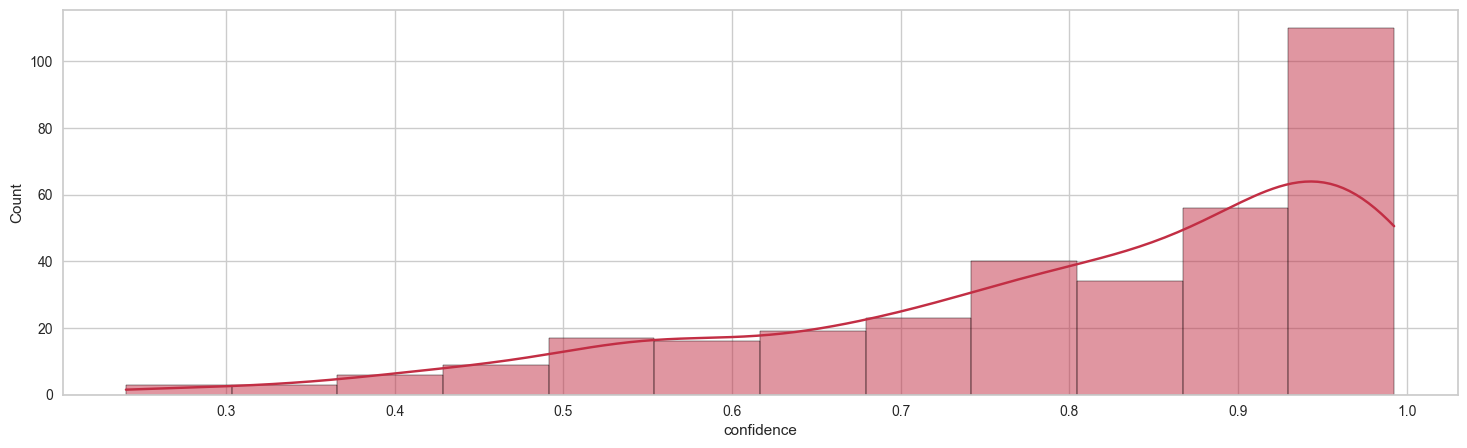

In [277]:
# Barchart for confidence
plt.figure(figsize=(18, 5))

#sns.histplot(data = df_train_dataset, x='confidence')
sns.histplot(data = df_validate, x='confidence', kde = True, color = dark)

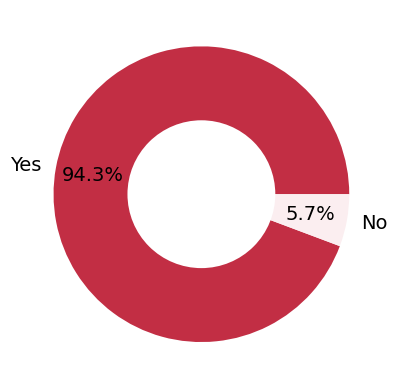

In [74]:
df_validate['keep'] = np.where(df_validate['confidence'] <= 0.5, 'No', 'Yes')

# Donut plot
label = list(pd.Series(df_validate['keep']).value_counts().index)
count = list(pd.Series(df_validate['keep']).value_counts().values)

colors = [dark, light]
#explode = (0.05, 0.05)
plt.pie(count, colors=colors, labels=label,
        autopct='%1.1f%%', pctdistance=0.75, textprops={'fontsize': 14})
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [97]:
# Clean Filename column

file_name_clean = []
for i in range(len(df_validate)):
    
    path = df_validate['Filename'][i]
    file_name = get_file_name(path)
    file_name_clean.append(file_name)

df_validate['file_name_clean']=file_name_clean

##### Processing TEST folder

__Note__: the script was interrupted several times due to "time-out" error and run in 3 batches [1-1667; 2888-5895]

In [505]:
# Batch n.1

dir_path = "/Users/admin/Downloads/archive (3)/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test/"
audio_files = os.listdir(dir_path)

# Create a recognizer object
r = sr.Recognizer()

# Create empty lists to store text and filename
text_list = []
filename_list = []

# Process each audio file
for audio_file in tqdm(audio_files, desc="Processing"):
    try:
        audio_path = os.path.join(dir_path, audio_file)

        # Open the audio file
        with sr.AudioFile(audio_path) as source:
            # Read the audio data
            audio_data = r.record(source)

        # Convert speech to text
        text = r.recognize_google(audio_data, show_all=True)

        # Append text and filename to lists
        text_list.append(text)
        filename_list.append(audio_file)

    except sr.RequestError as e:
        print(f"Error processing audio file: {audio_file} - {e}")
        continue
    
    except sr.UnknownValueError:
        print(f"No speech detected in audio file: {audio_file}")
        continue


Processing:   1%|▏                          | 38/5895 [00:41<1:18:04,  1.25it/s]

Error processing audio file: 1249120_43825820_74870170.wav - recognition request failed: Bad Request


Processing:   2%|▍                         | 113/5895 [01:54<1:18:10,  1.23it/s]

Error processing audio file: 1249120_27392644_61488621.wav - recognition request failed: Bad Request


Processing:   3%|▋                         | 163/5895 [02:49<1:12:05,  1.33it/s]

Error processing audio file: 1249120_43825820_27367589.wav - recognition request failed: Bad Request


Processing:   3%|▊                         | 186/5895 [03:08<1:13:29,  1.29it/s]

Error processing audio file: 1249120_43825820_36711619.wav - recognition request failed: Bad Request


Processing:   4%|▉                         | 212/5895 [03:36<1:13:19,  1.29it/s]

Error processing audio file: 1249120_27392644_22855056.wav - recognition request failed: Bad Request


Processing:   4%|▉                         | 219/5895 [03:41<1:09:03,  1.37it/s]

Error processing audio file: 1249120_15965551_85311616.wav - recognition request failed: Bad Request


Processing:   4%|█▏                        | 258/5895 [04:15<1:04:47,  1.45it/s]

Error processing audio file: 1249120_43825820_101160618.wav - recognition request failed: Bad Request


Processing:   4%|█▏                        | 264/5895 [04:19<1:00:36,  1.55it/s]

Error processing audio file: 1249120_27392644_51466522.wav - recognition request failed: Bad Request


Processing:   5%|█▎                        | 292/5895 [04:50<1:41:58,  1.09s/it]

Error processing audio file: 1249120_27392644_71841210.wav - recognition request failed: Bad Request


Processing:   6%|█▍                        | 340/5895 [05:42<1:12:50,  1.27it/s]

Error processing audio file: 1249120_27392644_90121653.wav - recognition request failed: Bad Request


Processing:   7%|█▊                        | 419/5895 [07:01<1:03:26,  1.44it/s]

Error processing audio file: 1249120_27392644_108937880.wav - recognition request failed: Bad Request


Processing:   8%|█▉                        | 451/5895 [07:30<1:02:16,  1.46it/s]

Error processing audio file: 1249120_43825820_17053909.wav - recognition request failed: Bad Request


Processing:   8%|██                        | 456/5895 [07:34<1:06:14,  1.37it/s]

Error processing audio file: 1249120_43825820_100017156.wav - recognition request failed: Bad Request


Processing:   8%|██▏                       | 494/5895 [08:18<1:11:26,  1.26it/s]

Error processing audio file: 1249120_27392644_24485200.wav - recognition request failed: Bad Request


Processing:   9%|██▎                       | 530/5895 [08:56<1:28:56,  1.01it/s]

Error processing audio file: 1249120_43825820_14018337.wav - recognition request failed: Bad Request


Processing:   9%|██▍                       | 553/5895 [09:15<1:07:41,  1.32it/s]

Error processing audio file: 1249120_27392644_90841863.wav - recognition request failed: Bad Request


Processing:   9%|██▋                         | 555/5895 [09:16<51:28,  1.73it/s]

Error processing audio file: 1249120_43825820_91878667.wav - recognition request failed: Bad Request


Processing:  10%|██▋                         | 573/5895 [09:33<53:54,  1.65it/s]

Error processing audio file: 1249120_43825820_54489855.wav - recognition request failed: Bad Request


Processing:  10%|██▌                       | 591/5895 [09:48<1:07:25,  1.31it/s]

Error processing audio file: 1249120_27392644_108841687.wav - recognition request failed: Bad Request


Processing:  10%|██▊                         | 595/5895 [09:51<52:28,  1.68it/s]

Error processing audio file: 1249120_27392644_40583011.wav - recognition request failed: Bad Request


Processing:  11%|███                         | 647/5895 [10:45<48:22,  1.81it/s]

Error processing audio file: 1249120_15965551_99791985.wav - recognition request failed: Bad Request


Processing:  12%|███                       | 704/5895 [11:49<1:02:16,  1.39it/s]

Error processing audio file: 1249120_43825820_24821264.wav - recognition request failed: Bad Request


Processing:  12%|███▍                        | 719/5895 [12:03<52:39,  1.64it/s]

Error processing audio file: 1249120_43825820_16563281.wav - recognition request failed: Bad Request


Processing:  12%|███▏                      | 727/5895 [12:10<1:21:29,  1.06it/s]

Error processing audio file: 1249120_43825820_92062316.wav - recognition request failed: Bad Request


Processing:  14%|███▌                      | 804/5895 [13:35<1:04:20,  1.32it/s]

Error processing audio file: 1249120_43825820_71284789.wav - recognition request failed: Bad Request


Processing:  14%|███▋                      | 846/5895 [14:20<1:22:41,  1.02it/s]

Error processing audio file: 1249120_43825820_17520297.wav - recognition request failed: Bad Request


Processing:  15%|███▊                      | 857/5895 [14:30<1:02:57,  1.33it/s]

Error processing audio file: 1249120_27392644_46688935.wav - recognition request failed: Bad Request


Processing:  15%|███▊                      | 864/5895 [14:38<1:21:05,  1.03it/s]

Error processing audio file: 1249120_27392644_67274549.wav - recognition request failed: Bad Request


Processing:  15%|████▎                       | 910/5895 [15:18<59:16,  1.40it/s]

Error processing audio file: 1249120_43825820_32759420.wav - recognition request failed: Bad Request


Processing:  16%|████▍                       | 946/5895 [15:56<53:32,  1.54it/s]

Error processing audio file: 1249120_27392644_93850585.wav - recognition request failed: Bad Request


Processing:  16%|████▌                       | 952/5895 [16:02<59:26,  1.39it/s]

Error processing audio file: 1249120_43825820_39428853.wav - recognition request failed: Bad Request


Processing:  17%|████▎                    | 1019/5895 [17:24<2:13:19,  1.64s/it]

Error processing audio file: 1249120_43825820_108025675.wav - recognition request failed: Bad Request


Processing:  18%|████▍                    | 1037/5895 [17:47<1:11:51,  1.13it/s]

Error processing audio file: 1249120_43825820_46159261.wav - recognition request failed: Bad Request


Processing:  18%|████▊                      | 1064/5895 [18:12<59:28,  1.35it/s]

Error processing audio file: 1249120_43825820_81980611.wav - recognition request failed: Bad Request


Processing:  18%|████▉                      | 1080/5895 [18:28<56:01,  1.43it/s]

Error processing audio file: 1249120_27392644_50730593.wav - recognition request failed: Bad Request


Processing:  19%|█████▏                     | 1145/5895 [19:38<56:02,  1.41it/s]

Error processing audio file: 1249120_15965551_30586097.wav - recognition request failed: Bad Request


Processing:  20%|█████▍                     | 1178/5895 [20:27<51:03,  1.54it/s]

Error processing audio file: 1249120_43825820_77844964.wav - recognition request failed: Bad Request


Processing:  20%|█████▍                     | 1197/5895 [20:43<53:47,  1.46it/s]

Error processing audio file: 1249120_43825820_31649758.wav - recognition request failed: Bad Request


Processing:  22%|█████▉                     | 1302/5895 [22:26<59:14,  1.29it/s]

Error processing audio file: 1249120_27392644_57021502.wav - recognition request failed: Bad Request


Processing:  23%|██████▏                    | 1350/5895 [23:09<41:33,  1.82it/s]

Error processing audio file: 1249120_43825820_20029602.wav - recognition request failed: Bad Request


Processing:  23%|██████▎                    | 1384/5895 [23:36<42:33,  1.77it/s]

Error processing audio file: 1249120_43825820_92518529.wav - recognition request failed: Bad Request


Processing:  25%|██████▋                    | 1454/5895 [24:42<57:26,  1.29it/s]

Error processing audio file: 1249120_27392644_67906647.wav - recognition request failed: Bad Request


Processing:  27%|███████▎                   | 1594/5895 [28:28<44:42,  1.60it/s]

Error processing audio file: 1249120_15965551_25492795.wav - recognition request failed: Bad Request


Processing:  27%|██████▊                  | 1601/5895 [28:37<1:05:28,  1.09it/s]

Error processing audio file: 1249120_27392644_36725519.wav - recognition request failed: Bad Request


Processing:  28%|███████▍                   | 1626/5895 [28:59<42:19,  1.68it/s]

Error processing audio file: 1249120_27392644_12852027.wav - recognition request failed: Bad Request


Processing:  28%|███████▌                   | 1661/5895 [29:47<51:49,  1.36it/s]

Error processing audio file: 1249120_43825820_71609763.wav - recognition request failed: Bad Request


Processing:  28%|███████▋                   | 1668/5895 [29:51<42:43,  1.65it/s]

Error processing audio file: 1249120_27392644_60092505.wav - recognition request failed: Bad Request


Processing:  29%|███████▊                   | 1706/5895 [30:31<58:08,  1.20it/s]

Error processing audio file: 1249120_39438102_41188383.wav - recognition connection failed: [Errno 32] Broken pipe


Processing:  30%|████████                   | 1756/5895 [31:15<52:08,  1.32it/s]

Error processing audio file: 1249120_43825820_39010582.wav - recognition request failed: Bad Request


Processing:  31%|████████▎                  | 1808/5895 [32:08<59:55,  1.14it/s]

Error processing audio file: 1249120_43825820_91557495.wav - recognition request failed: Bad Request


Processing:  31%|███████▋                 | 1817/5895 [32:21<1:29:18,  1.31s/it]

Error processing audio file: 1249120_27392644_32957316.wav - recognition request failed: Bad Request


Processing:  31%|████████▎                  | 1828/5895 [32:28<43:45,  1.55it/s]

Error processing audio file: 1249120_27392644_44306106.wav - recognition request failed: Bad Request


Processing:  32%|████████▌                  | 1882/5895 [33:24<50:06,  1.33it/s]

Error processing audio file: 1249120_27392644_98494460.wav - recognition request failed: Bad Request


Processing:  33%|████████▊                  | 1928/5895 [34:07<57:41,  1.15it/s]

Error processing audio file: 1249120_43825820_53165761.wav - recognition request failed: Bad Request


Processing:  33%|████████▉                  | 1957/5895 [34:35<39:54,  1.64it/s]

Error processing audio file: 1249120_43825820_64955471.wav - recognition request failed: Bad Request


Processing:  33%|████████▎                | 1970/5895 [34:48<1:00:42,  1.08it/s]

Error processing audio file: 1249120_43825820_37623093.wav - recognition request failed: Bad Request


Processing:  34%|█████████▎                 | 2029/5895 [35:35<45:43,  1.41it/s]

Error processing audio file: 1249120_27392644_69422505.wav - recognition request failed: Bad Request


Processing:  36%|█████████▌                 | 2097/5895 [36:39<45:40,  1.39it/s]

Error processing audio file: 1249120_15965551_53555531.wav - recognition request failed: Bad Request


Processing:  37%|█████████▉                 | 2170/5895 [37:45<35:02,  1.77it/s]

Error processing audio file: 1249120_43825820_82145177.wav - recognition request failed: Bad Request


Processing:  37%|█████████▉                 | 2177/5895 [37:52<50:54,  1.22it/s]

Error processing audio file: 1249120_43825820_90943169.wav - recognition request failed: Bad Request


Processing:  38%|██████████▏                | 2221/5895 [38:36<47:32,  1.29it/s]

Error processing audio file: 1249120_43825820_43097429.wav - recognition request failed: Bad Request


Processing:  38%|██████████▏                | 2225/5895 [38:38<32:26,  1.89it/s]

Error processing audio file: 1249120_15965551_42589900.wav - recognition request failed: Bad Request


Processing:  40%|██████████▋                | 2341/5895 [40:30<35:40,  1.66it/s]

Error processing audio file: 1249120_43825820_91624765.wav - recognition request failed: Bad Request


Processing:  40%|██████████▊                | 2363/5895 [40:54<47:45,  1.23it/s]

Error processing audio file: 1249120_15965551_20749336.wav - recognition request failed: Bad Request


Processing:  41%|███████████                | 2403/5895 [41:32<48:53,  1.19it/s]

Error processing audio file: 1249120_43825820_28134776.wav - recognition request failed: Bad Request


Processing:  41%|███████████                | 2409/5895 [41:35<29:45,  1.95it/s]

Error processing audio file: 1249120_27392644_104298492.wav - recognition request failed: Bad Request


Processing:  41%|███████████                | 2419/5895 [41:45<41:44,  1.39it/s]

Error processing audio file: 1249120_43825820_44998707.wav - recognition request failed: Bad Request


Processing:  42%|███████████▏               | 2452/5895 [42:23<53:42,  1.07it/s]

Error processing audio file: 1249120_27392644_45411334.wav - recognition request failed: Bad Request


Processing:  42%|███████████▍               | 2488/5895 [43:02<48:37,  1.17it/s]

Error processing audio file: 1249120_15965551_57015604.wav - recognition request failed: Bad Request


Processing:  43%|███████████▋               | 2559/5895 [44:08<38:01,  1.46it/s]

Error processing audio file: 1249120_15965551_35401223.wav - recognition request failed: Bad Request


Processing:  44%|██████████▉              | 2566/5895 [44:18<1:04:25,  1.16s/it]

Error processing audio file: 1249120_27392644_78038831.wav - recognition request failed: Bad Request


Processing:  44%|███████████▉               | 2603/5895 [44:51<53:45,  1.02it/s]

Error processing audio file: 1249120_43825820_98687117.wav - recognition request failed: Bad Request


Processing:  44%|███████████▉               | 2606/5895 [44:52<34:42,  1.58it/s]

Error processing audio file: 1249120_15965551_64987640.wav - recognition request failed: Bad Request


Processing:  44%|███████████▉               | 2608/5895 [44:54<33:49,  1.62it/s]

Error processing audio file: 1249120_43825820_56083833.wav - recognition request failed: Bad Request


Processing:  45%|████████████               | 2643/5895 [45:36<37:53,  1.43it/s]

Error processing audio file: 1249120_43825820_68671190.wav - recognition request failed: Bad Request


Processing:  45%|████████████▏              | 2658/5895 [45:50<38:06,  1.42it/s]

Error processing audio file: 1249120_27392644_85731623.wav - recognition request failed: Bad Request


Processing:  45%|████████████▏              | 2670/5895 [46:04<51:19,  1.05it/s]

Error processing audio file: 1249120_15965551_41232322.wav - recognition request failed: Bad Request


Processing:  45%|████████████▏              | 2673/5895 [46:07<46:21,  1.16it/s]

Error processing audio file: 1249120_15965551_98145234.wav - recognition request failed: Bad Request


Processing:  46%|████████████▎              | 2685/5895 [46:18<37:17,  1.43it/s]

Error processing audio file: 1249120_27392644_102861636.wav - recognition request failed: Bad Request


Processing:  46%|████████████▎              | 2687/5895 [46:19<28:23,  1.88it/s]

Error processing audio file: 1249120_43825820_51160700.wav - recognition request failed: Bad Request


Processing:  46%|████████████▎              | 2692/5895 [46:23<34:01,  1.57it/s]

Error processing audio file: 1249120_27392644_45502941.wav - recognition request failed: Bad Request


Processing:  46%|████████████▍              | 2702/5895 [46:34<45:03,  1.18it/s]

Error processing audio file: 1249120_43825820_57474624.wav - recognition request failed: Bad Request
Error processing audio file: 1249120_43825820_77029615.wav - recognition request failed: Bad Request


Processing:  46%|████████████▍              | 2711/5895 [46:40<32:28,  1.63it/s]

Error processing audio file: 1249120_43825820_14698523.wav - recognition request failed: Bad Request


Processing:  46%|████████████▍              | 2729/5895 [47:01<45:05,  1.17it/s]

Error processing audio file: 1249120_43825820_22702560.wav - recognition request failed: Bad Request


Processing:  47%|████████████▌              | 2744/5895 [47:16<40:39,  1.29it/s]

Error processing audio file: 1249120_27392644_30360688.wav - recognition request failed: Bad Request


Processing:  47%|████████████▌              | 2754/5895 [47:24<36:55,  1.42it/s]

Error processing audio file: 1249120_27392644_84663890.wav - recognition request failed: Bad Request


Processing:  49%|█████████████▏             | 2886/5895 [49:36<58:16,  1.16s/it]

Error processing audio file: 1249120_27392644_86164706.wav - recognition request failed: Bad Request


Processing:  49%|█████████████▎             | 2916/5895 [50:04<29:51,  1.66it/s]

Error processing audio file: 1249120_27392644_48243205.wav - recognition request failed: Bad Request


Processing:  50%|█████████████▍             | 2934/5895 [50:21<33:04,  1.49it/s]

Error processing audio file: 1249120_27392644_71854860.wav - recognition request failed: Bad Request


Processing:  50%|█████████████▌             | 2962/5895 [50:45<45:54,  1.06it/s]

Error processing audio file: 1249120_43825820_88800778.wav - recognition request failed: Bad Request


Processing:  51%|█████████████▋             | 2978/5895 [51:00<30:43,  1.58it/s]

Error processing audio file: 1249120_27392644_57558452.wav - recognition request failed: Bad Request


Processing:  51%|█████████████▊             | 3021/5895 [51:41<52:01,  1.09s/it]

Error processing audio file: 1249120_43825820_37980920.wav - recognition request failed: Bad Request


Processing:  52%|██████████████             | 3060/5895 [52:16<37:15,  1.27it/s]

Error processing audio file: 1249120_27392644_26489438.wav - recognition request failed: Bad Request


Processing:  53%|██████████████▏            | 3106/5895 [53:04<34:23,  1.35it/s]

Error processing audio file: 1249120_27392644_55509323.wav - recognition request failed: Bad Request


Processing:  53%|██████████████▎            | 3129/5895 [53:25<28:46,  1.60it/s]

Error processing audio file: 1249120_27392644_15572920.wav - recognition request failed: Bad Request


Processing:  53%|██████████████▎            | 3136/5895 [53:34<46:14,  1.01s/it]

Error processing audio file: 1249120_27392644_11875466.wav - recognition request failed: Bad Request


Processing:  54%|█████████████▍           | 3183/5895 [54:27<1:05:18,  1.44s/it]

Error processing audio file: 1249120_43825820_79658475.wav - recognition request failed: Bad Request


Processing:  54%|██████████████▌            | 3189/5895 [54:31<34:58,  1.29it/s]

Error processing audio file: 1249120_27392644_79601061.wav - recognition request failed: Bad Request


Processing:  55%|██████████████▉            | 3259/5895 [55:42<35:20,  1.24it/s]

Error processing audio file: 1249120_27392644_88966581.wav - recognition request failed: Bad Request


Processing:  55%|██████████████▉            | 3271/5895 [55:53<26:38,  1.64it/s]

Error processing audio file: 1249120_43825820_106948055.wav - recognition request failed: Bad Request


Processing:  56%|█████████████▉           | 3281/5895 [56:29<1:48:54,  2.50s/it]

Error processing audio file: 1249120_27392644_73339356.wav - recognition request failed: Bad Request


Processing:  56%|███████████████            | 3302/5895 [56:47<30:19,  1.43it/s]

Error processing audio file: 1249120_43825820_86733021.wav - recognition request failed: Bad Request


Processing:  56%|███████████████▏           | 3326/5895 [57:12<31:39,  1.35it/s]

Error processing audio file: 1249120_43825820_80178644.wav - recognition request failed: Bad Request


Processing:  56%|███████████████▏           | 3327/5895 [57:12<25:27,  1.68it/s]

Error processing audio file: 1249120_27392644_92472837.wav - recognition request failed: Bad Request


Processing:  57%|███████████████▎           | 3345/5895 [57:32<28:11,  1.51it/s]

Error processing audio file: 1249120_43825820_100024735.wav - recognition request failed: Bad Request


Processing:  57%|███████████████▎           | 3351/5895 [57:37<36:05,  1.17it/s]

Error processing audio file: 1249120_43825820_33778806.wav - recognition request failed: Bad Request


Processing:  58%|███████████████▌           | 3411/5895 [58:34<28:10,  1.47it/s]

Error processing audio file: 1249120_27392644_103554308.wav - recognition request failed: Bad Request


Processing:  59%|██████████████▊          | 3504/5895 [1:00:08<38:59,  1.02it/s]

Error processing audio file: 1249120_43825820_29912942.wav - recognition request failed: Bad Request


Processing:  60%|██████████████▉          | 3523/5895 [1:00:31<45:41,  1.16s/it]

Error processing audio file: 1249120_43825820_20594643.wav - recognition request failed: Bad Request


Processing:  61%|███████████████▎         | 3596/5895 [1:01:44<35:56,  1.07it/s]

Error processing audio file: 1249120_43825820_104241768.wav - recognition request failed: Bad Request


Processing:  63%|███████████████▋         | 3710/5895 [1:04:03<25:04,  1.45it/s]

Error processing audio file: 1249120_27392644_73969603.wav - recognition request failed: Bad Request


Processing:  63%|███████████████▊         | 3717/5895 [1:04:09<26:11,  1.39it/s]

Error processing audio file: 1249120_43825820_30923784.wav - recognition request failed: Bad Request


Processing:  64%|███████████████▉         | 3754/5895 [1:04:46<30:14,  1.18it/s]

Error processing audio file: 1249120_15965551_50224784.wav - recognition request failed: Bad Request


Processing:  64%|████████████████         | 3784/5895 [1:05:17<32:54,  1.07it/s]

Error processing audio file: 1249120_27392644_45319671.wav - recognition request failed: Bad Request


Processing:  65%|████████████████▏        | 3829/5895 [1:06:03<22:32,  1.53it/s]

Error processing audio file: 1249120_27392644_64208392.wav - recognition request failed: Bad Request


Processing:  65%|████████████████▎        | 3841/5895 [1:06:13<22:31,  1.52it/s]

Error processing audio file: 1249120_27392644_32901200.wav - recognition request failed: Bad Request


Processing:  65%|████████████████▎        | 3859/5895 [1:06:29<22:01,  1.54it/s]

Error processing audio file: 1249120_41221824_50825515.wav - recognition connection failed: [Errno 32] Broken pipe


Processing:  66%|████████████████▍        | 3868/5895 [1:06:37<18:20,  1.84it/s]

Error processing audio file: 1249120_43825820_71713244.wav - recognition request failed: Bad Request


Processing:  66%|████████████████▌        | 3897/5895 [1:07:08<30:45,  1.08it/s]

Error processing audio file: 1249120_27392644_42382970.wav - recognition request failed: Bad Request


Processing:  67%|████████████████▋        | 3929/5895 [1:07:39<17:45,  1.85it/s]

Error processing audio file: 1249120_43825820_25793996.wav - recognition request failed: Bad Request


Processing:  68%|████████████████▉        | 4000/5895 [1:08:44<18:26,  1.71it/s]

Error processing audio file: 1249120_15965551_82958180.wav - recognition request failed: Bad Request


Processing:  68%|█████████████████        | 4013/5895 [1:08:53<17:52,  1.75it/s]

Error processing audio file: 1249120_43825820_106367676.wav - recognition request failed: Bad Request


Processing:  68%|█████████████████        | 4037/5895 [1:09:24<35:23,  1.14s/it]

Error processing audio file: 1249120_43825820_93161773.wav - recognition request failed: Bad Request


Processing:  69%|█████████████████▏       | 4040/5895 [1:09:25<22:17,  1.39it/s]

Error processing audio file: 1249120_43825820_39335945.wav - recognition request failed: Bad Request


Processing:  69%|█████████████████▏       | 4058/5895 [1:09:44<22:56,  1.33it/s]

Error processing audio file: 1249120_43825820_88279891.wav - recognition request failed: Bad Request


Processing:  70%|█████████████████▌       | 4148/5895 [1:11:27<21:46,  1.34it/s]

Error processing audio file: 1249120_43825820_86209370.wav - recognition request failed: Bad Request


Processing:  71%|█████████████████▋       | 4163/5895 [1:11:42<28:19,  1.02it/s]

Error processing audio file: 1249120_43825820_109122878.wav - recognition request failed: Bad Request


Processing:  71%|█████████████████▊       | 4191/5895 [1:12:08<17:21,  1.64it/s]

Error processing audio file: 1249120_27392644_57763110.wav - recognition request failed: Bad Request


Processing:  72%|█████████████████▉       | 4219/5895 [1:12:41<31:34,  1.13s/it]

Error processing audio file: 1249120_27392644_104240554.wav - recognition request failed: Bad Request


Processing:  72%|█████████████████▉       | 4236/5895 [1:12:56<18:06,  1.53it/s]

Error processing audio file: 1249120_27392644_38977443.wav - recognition request failed: Bad Request


Processing:  72%|██████████████████       | 4248/5895 [1:13:10<28:57,  1.06s/it]

Error processing audio file: 1249120_43825820_96179858.wav - recognition request failed: Bad Request


Processing:  73%|██████████████████▏      | 4284/5895 [1:13:47<22:43,  1.18it/s]

Error processing audio file: 1249120_43825820_35431926.wav - recognition request failed: Bad Request


Processing:  74%|██████████████████▌      | 4364/5895 [1:15:07<20:37,  1.24it/s]

Error processing audio file: 1249120_43825820_58680972.wav - recognition request failed: Bad Request


Processing:  76%|██████████████████▉      | 4476/5895 [1:16:59<15:27,  1.53it/s]

Error processing audio file: 1249120_27392644_19148860.wav - recognition request failed: Bad Request


Processing:  77%|███████████████████▏     | 4539/5895 [1:18:06<15:19,  1.48it/s]

Error processing audio file: 1249120_43825820_59175540.wav - recognition request failed: Bad Request


Processing:  77%|███████████████████▎     | 4556/5895 [1:18:21<14:04,  1.59it/s]

Error processing audio file: 1249120_27392644_107604574.wav - recognition request failed: Bad Request


Processing:  78%|███████████████████▌     | 4605/5895 [1:19:09<16:52,  1.27it/s]

Error processing audio file: 1249120_43453425_10450489.wav - recognition connection failed: [Errno 32] Broken pipe


Processing:  80%|███████████████████▉     | 4699/5895 [1:21:01<15:36,  1.28it/s]

Error processing audio file: 1249120_27392644_10424458.wav - recognition request failed: Bad Request


Processing:  80%|████████████████████     | 4716/5895 [1:21:20<13:27,  1.46it/s]

Error processing audio file: 1249120_43825820_23278432.wav - recognition request failed: Bad Request


Processing:  81%|████████████████████▏    | 4750/5895 [1:21:50<08:32,  2.23it/s]

Error processing audio file: 1249120_27392644_81365534.wav - recognition request failed: Bad Request
Error processing audio file: 1249120_27392644_37594410.wav - recognition request failed: Bad Request


Processing:  81%|████████████████████▎    | 4803/5895 [1:22:53<15:50,  1.15it/s]

Error processing audio file: 1249120_15965551_65155573.wav - recognition request failed: Bad Request


Processing:  82%|████████████████████▍    | 4805/5895 [1:22:54<11:19,  1.60it/s]

Error processing audio file: 1249120_27392644_11836461.wav - recognition request failed: Bad Request


Processing:  83%|████████████████████▋    | 4882/5895 [1:24:12<17:32,  1.04s/it]

Error processing audio file: 1249120_27392644_94581488.wav - recognition request failed: Bad Request


Processing:  83%|████████████████████▊    | 4893/5895 [1:24:22<11:48,  1.41it/s]

Error processing audio file: 1249120_43825820_28617748.wav - recognition request failed: Bad Request


Processing:  84%|████████████████████▉    | 4923/5895 [1:24:49<12:10,  1.33it/s]

Error processing audio file: 1249120_27392644_96110509.wav - recognition request failed: Bad Request


Processing:  84%|████████████████████▉    | 4947/5895 [1:25:12<10:21,  1.52it/s]

Error processing audio file: 1249120_27392644_61751864.wav - recognition request failed: Bad Request


Processing:  84%|█████████████████████    | 4961/5895 [1:25:30<15:07,  1.03it/s]

Error processing audio file: 1249120_15965551_44782675.wav - recognition request failed: Bad Request


Processing:  85%|█████████████████████▏   | 5010/5895 [1:26:24<12:08,  1.21it/s]

Error processing audio file: 1249120_27392644_15838768.wav - recognition request failed: Bad Request


Processing:  85%|█████████████████████▎   | 5028/5895 [1:26:40<09:07,  1.58it/s]

Error processing audio file: 1249120_27392644_79053520.wav - recognition request failed: Bad Request


Processing:  87%|█████████████████████▊   | 5154/5895 [1:28:49<08:53,  1.39it/s]

Error processing audio file: 1249120_27392644_27648433.wav - recognition request failed: Bad Request


Processing:  87%|█████████████████████▊   | 5156/5895 [1:28:50<07:18,  1.68it/s]

Error processing audio file: 1249120_15965551_75075551.wav - recognition request failed: Bad Request


Processing:  89%|██████████████████████▏  | 5218/5895 [1:29:53<09:50,  1.15it/s]

Error processing audio file: 1249120_15965551_67804099.wav - recognition request failed: Bad Request


Processing:  89%|██████████████████████▏  | 5235/5895 [1:30:10<10:19,  1.07it/s]

Error processing audio file: 1249120_27392644_66504506.wav - recognition request failed: Bad Request


Processing:  89%|██████████████████████▎  | 5258/5895 [1:30:27<06:24,  1.66it/s]

Error processing audio file: 1249120_27392644_55464974.wav - recognition request failed: Bad Request


Processing:  91%|██████████████████████▋  | 5360/5895 [1:32:06<07:20,  1.22it/s]

Error processing audio file: 1249120_43825820_36808011.wav - recognition request failed: Bad Request


Processing:  91%|██████████████████████▊  | 5379/5895 [1:32:24<06:06,  1.41it/s]

Error processing audio file: 1249120_43825820_93799186.wav - recognition request failed: Bad Request


Processing:  91%|██████████████████████▊  | 5384/5895 [1:32:32<11:55,  1.40s/it]

Error processing audio file: 1249120_15965551_65583273.wav - recognition request failed: Bad Request


Processing:  93%|███████████████████████▎ | 5501/5895 [1:34:15<03:51,  1.70it/s]

Error processing audio file: 1249120_27392644_45860516.wav - recognition request failed: Bad Request


Processing:  94%|███████████████████████▍ | 5526/5895 [1:34:39<04:29,  1.37it/s]

Error processing audio file: 1249120_27392644_55099831.wav - recognition request failed: Bad Request


Processing:  95%|███████████████████████▋ | 5579/5895 [1:35:28<04:08,  1.27it/s]

Error processing audio file: 1249120_27392644_72270632.wav - recognition request failed: Bad Request


Processing:  95%|███████████████████████▋ | 5581/5895 [1:35:30<04:18,  1.21it/s]

Error processing audio file: 1249120_15965551_82673379.wav - recognition request failed: Bad Request


Processing:  95%|███████████████████████▊ | 5621/5895 [1:36:07<02:52,  1.59it/s]

Error processing audio file: 1249120_15965551_63975814.wav - recognition request failed: Bad Request


Processing:  96%|████████████████████████ | 5680/5895 [1:37:06<02:18,  1.55it/s]

Error processing audio file: 1249120_27392644_15083037.wav - recognition request failed: Bad Request


Processing:  96%|████████████████████████ | 5682/5895 [1:37:08<02:46,  1.28it/s]

Error processing audio file: 1249120_43825820_76325713.wav - recognition request failed: Bad Request


Processing:  97%|████████████████████████▏| 5700/5895 [1:37:27<01:39,  1.95it/s]

Error processing audio file: 1249120_43825820_24998638.wav - recognition request failed: Bad Request


Processing:  97%|████████████████████████▏| 5713/5895 [1:37:39<02:41,  1.12it/s]

Error processing audio file: 1249120_15965551_64170568.wav - recognition request failed: Bad Request


Processing:  98%|████████████████████████▍| 5756/5895 [1:38:22<01:32,  1.50it/s]

Error processing audio file: 1249120_43825820_49953408.wav - recognition request failed: Bad Request


Processing:  98%|████████████████████████▌| 5789/5895 [1:38:56<01:23,  1.26it/s]

Error processing audio file: 1249120_43825820_37458345.wav - recognition request failed: Bad Request


Processing: 100%|█████████████████████████| 5895/5895 [1:40:43<00:00,  1.03s/it]


In [541]:
# Create DataFrame
data = {"Text": text_list, "Filename": filename_list}
df_test = pd.DataFrame(data)
df_test.to_csv("df_test_part1.csv", index=False)

In [542]:
df_test = pd.read_csv("df_test_part1.csv")

In [543]:
df_test.shape # 5725, 2  ---> excluded 170 audios files 

(5725, 2)

In [547]:
# Clean Text column (keep 'transcript' and  'confidence' value) ---> use the function (once it is done) instaed

import ast

text_clean_lst = []
confidence_level_lst=[]

for i in range(len(df_test)):

    text = df_test.Text[i]
    if len(text) == 2:
        text_clean_lst.append(None)
        confidence_level_lst.append(None)
    else:
        try: 
            input_dict = ast.literal_eval(text)
            text_clean = input_dict['alternative'][0]['transcript']
            text_clean_lst.append(text_clean)


            confidence_level = input_dict['alternative'][0]['confidence']
            confidence_level_lst.append(confidence_level)

        except (ValueError, KeyError):
            continue

In [548]:
df_test['text_clean'] = text_clean_lst
df_test['confidence'] = confidence_level_lst

In [550]:
df_test.drop(columns=['Text'], inplace = True)

# Make a phrase-severity dictionary

In [552]:
ph_severity = pd.read_csv("phrase_severity.csv")
ph_severity.drop_duplicates(subset=['phrase'], keep='first', inplace = True)

In [553]:
ph_severity.head()

,severity,same_phrase,phrase
0,0,A,A terrible fall in hair
9,0,A,After a breakup I feel something strange in me.
21,0,A,After an hard working day I have foot ache
29,1,B,After eating I have burning sensation inside ...
41,0,A,"after playing football, i have muscle pain wit..."


In [554]:
overview = pd.read_csv("overview-of-recordings.csv")

In [555]:
ph_severity = overview.merge(ph_severity,how='outer', left_on='phrase', right_on='phrase')
# count Na
# 8 Na --> drop
ph_severity.isna().sum
ph_severity.dropna(inplace = True)

ph_severity.drop(columns=['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'writer_id', 'same_phrase' ], inplace = True)

In [556]:
ph_severity.columns = ['file_name', 'phrase_orig', 'prompt', 'severity']
ph_severity.columns

Index(['file_name', 'phrase_orig', 'prompt', 'severity', 'same_phrase'], dtype='object')

In [557]:
## Merge ph_severity with df_test by 'file_name'
df_test = df_test.merge(ph_severity, how='inner', left_on='Filename', right_on='file_name')

In [559]:
df_test.drop(columns=['Filename'], inplace = True)

In [565]:
# check for Nas (n=184)
df_test.isna().sum()
df_test.dropna(inplace = True)

In [570]:
# convert 'text_clean' and 'phrase_orig' to lower case and strip the text
df_test['text_clean'] = df_test['text_clean'].str.lower().str.strip()
df_test['phrase_orig'] = df_test['phrase_orig'].str.lower().str.strip()

In [572]:
# Keep only the row with the highest value in 'confidence' for each unique value in 'phrase_orig'
df_max = df_test.groupby('phrase_orig')['confidence'].idxmax()
df_test = df_test.loc[df_max]

In [577]:
df_test.head() # (695, 7)
df_test.reset_index(inplace = True, drop = True)

In [581]:
df_test.drop(columns=['phrase_orig'], inplace = True)

In [582]:
df_test

,text_clean,confidence,file_name,prompt,severity
0,a terrible fall in hair,0.990103,1249120_43577102_62787251.wav,Hair falling out,0.0
1,after a breakup i feel something strange in me,0.830414,1249120_44093933_109330064.wav,Emotional pain,0.0
2,oculuspartner,0.846174,1249120_42210938_72512880.wav,Foot ache,0.0
3,after eating i have burning sensation inside o...,0.987629,1249120_43856216_87143624.wav,Stomach ache,1.0
4,after playing football i have muscle pain with...,0.995087,1249120_41841195_57027955.wav,Muscle pain,0.0
...,...,...,...,...,...
690,when my grandfather died i felt a hard emotion...,0.987629,1249120_38042052_51397205.wav,Emotional pain,0.0
691,whenever i stand up i feel dizzy,0.987629,1249120_40725179_76574514.wav,Feeling dizzy,1.0
692,why is my shoulder aching when i try to pick u...,0.987629,1249120_22423108_32755063.wav,Shoulder pain,1.0
693,yesterday i had a shoulder pain,0.988415,1249120_41203338_74291763.wav,Shoulder pain,0.0


prompt
Acne                  34
Back pain             26
Blurry vision         26
Body feels weak       25
Cough                 31
Ear ache              28
Emotional pain        24
Feeling cold          27
Feeling dizzy         26
Foot ache             26
Hair falling out      27
Hard to breath        25
Head ache             26
Heart hurts           29
Infected wound        34
Injury from sports    26
Internal pain         26
Joint pain            33
Knee pain             32
Muscle pain           29
Neck pain             25
Open wound            21
Shoulder pain         34
Skin issue            28
Stomach ache          27
Name: prompt, dtype: int64

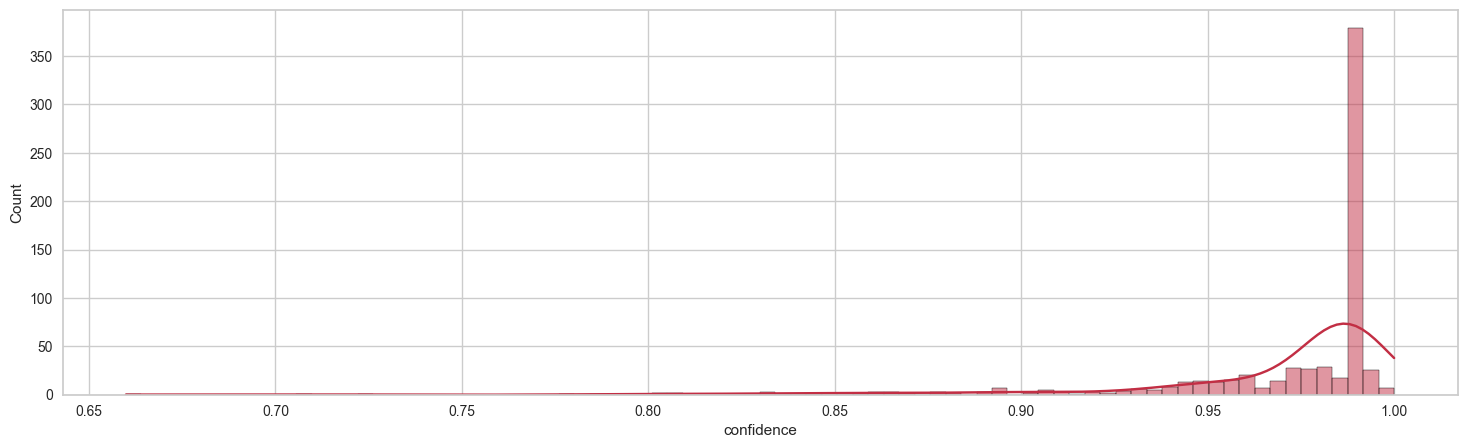

In [584]:
# Visualizing 'confidence' in a histogram
plt.figure(figsize=(18, 5))
sns.histplot(data = df_test, x='confidence', kde = True, color = dark)
plt.show()

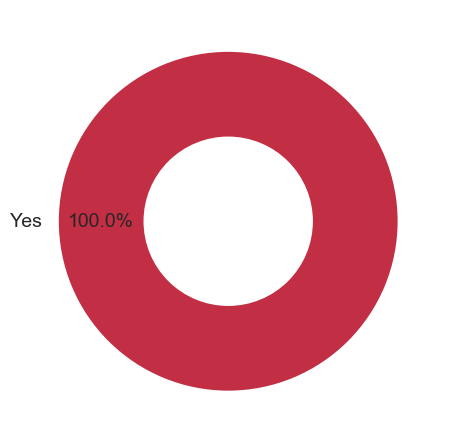

In [585]:
# Donut plot: how many audios are excluded because of bad quality?

df_test['keep'] = np.where(df_test['confidence'] <= 0.5, 'No', 'Yes')

label = list(pd.Series(df_test['keep']).value_counts().index)
count = list(pd.Series(df_test['keep']).value_counts().values)

colors = [dark, light]
#explode = (0.05, 0.05)
plt.pie(count, colors=colors, labels=label,
        autopct='%1.1f%%', pctdistance=0.75, textprops={'fontsize': 14})
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

## Exploratory analysis

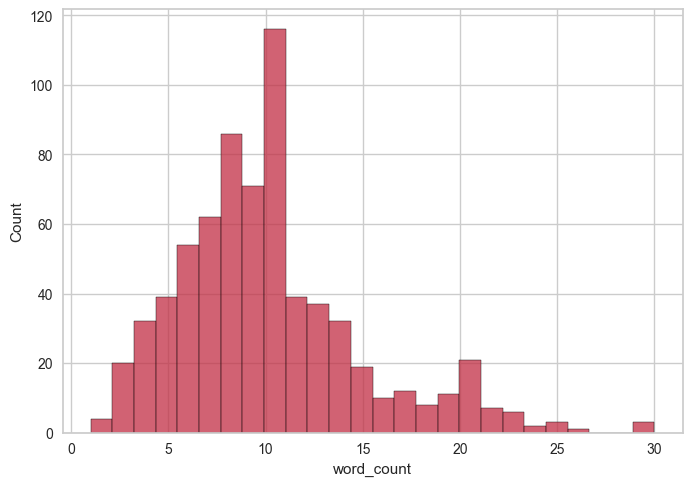

In [586]:
### Feautures about the text

# words count
df_test['word_count'] = df_test['text_clean'].apply(lambda x: len(str(x).split()))
sns.histplot(df_test, x='word_count', color = dark)
plt.show()

In [ ]:
### Features about the audio



# Classification unsupervised machine learning: severe vs mild

In [587]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import make_pipeline

In [588]:
# List ailments
text_list = list(df_test.text_clean)

# Create a TF-IDF vectorizer: converting text documents into numeric representations
# TF-IDF: it counts word frequency and gives a higher weighting to those words that appear less frequently. 
# Common words have a lower weighting, whereas words that are probably more domain-specific and appear 
# less will have a higher weighting.
vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF vectors
X = vectorizer.fit_transform(text_list)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/Users/admin/opt/anaconda3/lib/python3.9/si

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/Users/admin/opt/anaconda3/lib/python3.9/si

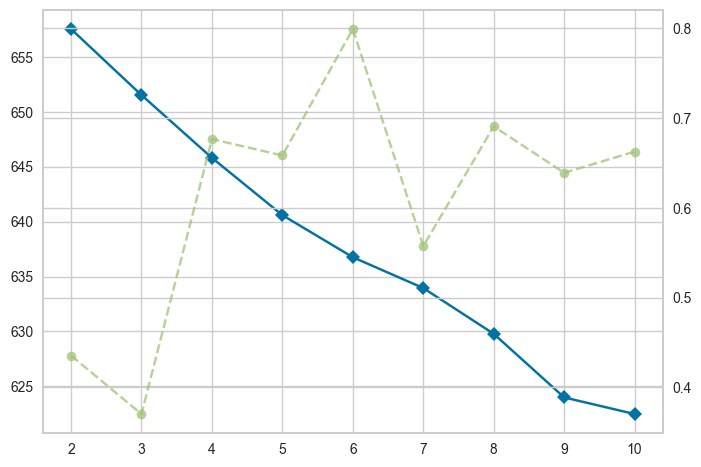

In [589]:
# number of clusters (Elbow method)

cluster = KElbowVisualizer(KMeans(n_init=15))
pipe = make_pipeline(cluster)

pipe.fit(X)
plt.show()
# it is just a reccomendation # no elbow detected

In [591]:
# Perform K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Classify the texts based on the cluster labels
classification = ["severe" if label == 1 else "mild"
                 for label in cluster_labels]

# the classification is really bad! 

Text: a terrible fall in hair
Classification: severe

Text: after a breakup i feel something strange in me
Classification: mild

Text: oculuspartner
Classification: severe

Text: after eating i have burning sensation inside of me
Classification: severe

Text: after playing football i have muscle pain with my both legs
Classification: mild

Text: after playing tennis i had a powerful sensation close to my neck
Classification: severe

Text: i have something under my phone
Classification: severe

Text: all my body is in a bad case and i need a good treatment
Classification: severe

Text: all of a sudden i felt dizzy when i stood up
Classification: severe

Text: annoying starts suddenly often after an injury or exercise
Classification: severe

Text: anytime i play tennis i feel a shoulder pain
Classification: mild

Text: at first it feels really numb better than a thousand needles start to pick up food
Classification: severe

Text: can't do any exercise i feel weak
Classification: severe



# Classification supervised machine learning: severe vs mild

In [593]:
# Suprvised machine learning classification
from cleantext import clean
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [594]:
# Drop if word_count < 2
df_test = df_test[df_test['word_count']>3]

In [595]:
## Clean dataset
df_test['text_clean_extra_clean'] = df_test['text_clean'].apply(do_clean)

/var/folders/gk/mp0xvl413dq_cb2pj579h7h00000gn/T/ipykernel_6241/4056662315.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [598]:
pd.Series(df_test.severity).value_counts()

severity
1.0    397
0.0    274
Name: count, dtype: int64

# Step 1 : classify cases that require doctor attention from the one that do not

In [652]:
# Split dataset
X = df_test['text_clean_extra_clean']
y = df_test['severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [653]:
# Feature engineering: TF-IDF Vectors as features

## The importance increases proportionally to the number of times a word appears in the review but is 
## offset by the frequency of the word in the entire review corpus.

## TF or Term Frequency measures how frequently a term appears in a document
## IDF or Inverse Document Frequency measures the importance of each term

tfidfconverter = TfidfVectorizer(max_features=10)
X_train_Tfidf_df = tfidfconverter.fit_transform(X_train).toarray()
X_train_Tfidf_df = pd.DataFrame(X_train_Tfidf_df)
X_test_Tfidf_df = tfidfconverter.transform(X_test).toarray()
X_test_Tfidf_df = pd.DataFrame(X_test_Tfidf_df)
X_train_Tfidf_df

# five columns representing the TF-IDF score. 
# It considers the top five words ordered by term frequency across the corpus of reviews.

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.0,0.000000,0.000000,0.395489,0.000000,0.360471,0.759259,0.0,0.370372
1,0.000000,0.0,0.856493,0.000000,0.000000,0.516159,0.000000,0.000000,0.0,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.0,0.640591,0.000000,0.000000,0.386047,0.663785,0.000000,0.0,0.000000
4,0.000000,0.0,0.571954,0.549598,0.000000,0.000000,0.000000,0.000000,0.0,0.608942
...,...,...,...,...,...,...,...,...,...,...
531,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
532,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
533,0.888232,0.0,0.000000,0.000000,0.309555,0.164092,0.000000,0.297141,0.0,0.000000
534,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [654]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, RocCurveDisplay


In [655]:
classifiers = [
    LogisticRegression(max_iter = 1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_jobs = -1),
    SVC(),
    GaussianNB(),
    KNeighborsClassifier(n_jobs = -1)
]

for classifier in classifiers:
    pipe = make_pipeline(classifier)
    grid = GridSearchCV(estimator = pipe, param_grid = {}, cv = 5, scoring = "recall")
    grid.fit(X_train_Tfidf_df, y_train)
    
    print(f"Train score for {classifier}: {grid.best_score_}")
    print("")

Train score for LogisticRegression(max_iter=1000): 0.8500768049155146

Train score for DecisionTreeClassifier(): 0.610189452124936

Train score for RandomForestClassifier(n_jobs=-1): 0.702662570404506

Train score for SVC(): 0.8081413210445468

Train score for GaussianNB(): 0.7094214029697901

Train score for KNeighborsClassifier(n_jobs=-1): 0.6836661546338967



## Summary 

df_test_validate_annotated.csv

__max_features=5__
- __Train score for LogisticRegression(max_iter=1000): 0.8838709677419356___
- Train score for DecisionTreeClassifier(): 0.7096774193548387
- Train score for RandomForestClassifier(n_jobs=-1): 0.7580645161290323
- __Train score for SVC(): 0.8741935483870968__
- Train score for GaussianNB(): 0.4967741935483872
- Train score for KNeighborsClassifier(n_jobs=-1): 0.5387096774193548

__max_features=10__
- Train score for LogisticRegression(max_iter=1000): 0.8258064516129032
- Train score for DecisionTreeClassifier(): 0.5870967741935483
- Train score for RandomForestClassifier(n_jobs=-1): 0.7096774193548387
- Train score for SVC(): 0.7774193548387097
- Train score for GaussianNB(): 0.635483870967742
- Train score for KNeighborsClassifier(n_jobs=-1): 0.6258064516129032

__max_features=15__
- Train score for LogisticRegression(max_iter=1000): 0.8225806451612904
- Train score for DecisionTreeClassifier(): 0.5870967741935484
- Train score for RandomForestClassifier(n_jobs=-1): 0.7225806451612904
- Train score for SVC(): 0.7870967741935484
- Train score for GaussianNB(): 0.632258064516129
- Train score for KNeighborsClassifier(n_jobs=-1): 0.6451612903225806


# SVC

In [656]:
param_grid_svc={
    'svc__C' : [1,2,4],
    'svc__gamma' : [1, 0.1,"auto", "scale"]    
}

classifier = SVC()
pipe= make_pipeline(classifier)

grid_svc =GridSearchCV(estimator = pipe, 
                          param_grid = param_grid_svc,
                          cv = 5,
                          scoring = "recall")

grid_svc.fit(X_train_Tfidf_df, y_train)

print(f"Best score: {grid_svc.best_score_}")
print(f"Best params: {grid_svc.best_params_}")

Best score: 0.9171018945212495
Best params: {'svc__C': 1, 'svc__gamma': 0.1}


0.6175373134328358
0.8977635782747604


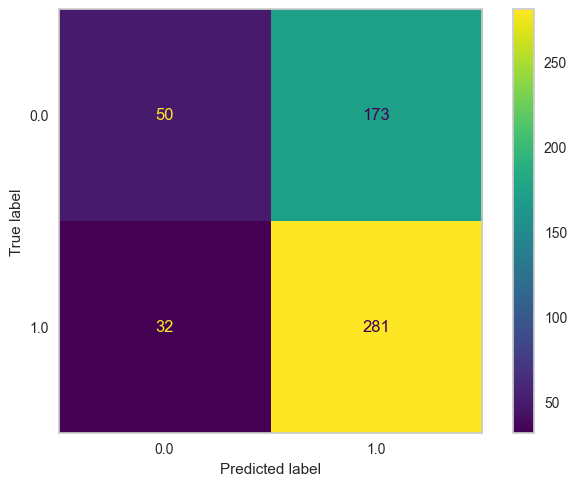

In [660]:
best_model = grid_svc.best_estimator_
best_model.fit(X_train_Tfidf_df, y_train)

y_pred = best_model.predict(X_train_Tfidf_df)

print(accuracy_score(y_train, y_pred))
print(recall_score(y_train, y_pred))

# confusion matrix
cm = confusion_matrix(y_train, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

disp.plot()
plt.grid(False)
plt.show()


In [658]:
# Evaluate model on test
y_pred = best_model.predict(X_test_Tfidf_df)

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.6296296296296297
0.8571428571428571


## Logistic Regression

In [661]:
param_grid_logreg={
    'logisticregression__C' : [0.01, 0.1, 1, 10]
}

classifier = LogisticRegression(max_iter=1000)
pipe= make_pipeline(classifier)

grid_logreg =GridSearchCV(estimator = pipe, 
                          param_grid = param_grid_logreg,
                          cv = 5,
                          scoring = "recall")

grid_logreg.fit(X_train_Tfidf_df, y_train)

print(f"Best score: {grid_logreg.best_score_}")
print(f"Best params: {grid_logreg.best_params_}")

Best score: 1.0
Best params: {'logisticregression__C': 0.01}


0.5839552238805971
1.0


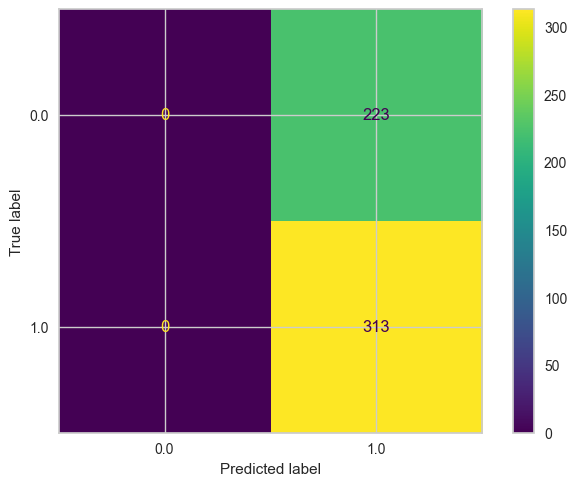

In [662]:
best_model = grid_logreg.best_estimator_
best_model.fit(X_train_Tfidf_df, y_train)

y_pred = best_model.predict(X_train_Tfidf_df)

print(accuracy_score(y_train, y_pred))
print(recall_score(y_train, y_pred))

# confusion matrix
cm = confusion_matrix(y_train, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

disp.plot()

plt.show()

In [663]:
# Evaluate model on test
y_pred = best_model.predict(X_test_Tfidf_df)

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.6222222222222222
1.0


# Part 2
## Create a model that given a text with ailments descroiption, it classifies it into a mediacl domain.

In [665]:
df_test.head()

,text_clean,confidence,file_name,prompt,severity,keep,word_count,text_clean_extra_clean
0,a terrible fall in hair,0.990103,1249120_43577102_62787251.wav,Hair falling out,0.0,Yes,5,a terrible fall in hair
1,after a breakup i feel something strange in me,0.830414,1249120_44093933_109330064.wav,Emotional pain,0.0,Yes,9,after a breakup i feel something strange in me
3,after eating i have burning sensation inside o...,0.987629,1249120_43856216_87143624.wav,Stomach ache,1.0,Yes,9,after eating i have burning sensation inside o...
4,after playing football i have muscle pain with...,0.995087,1249120_41841195_57027955.wav,Muscle pain,0.0,Yes,11,after playing football i have muscle pain with...
5,after playing tennis i had a powerful sensatio...,0.988203,1249120_33905644_36396763.wav,Shoulder pain,0.0,Yes,12,after playing tennis i had a powerful sensatio...


In [669]:
df_test['prompt'].unique()

array(['Hair falling out', 'Emotional pain', 'Stomach ache',
       'Muscle pain', 'Shoulder pain', 'Foot ache', 'Joint pain',
       'Feeling dizzy', 'Knee pain', 'Body feels weak', 'Acne',
       'Internal pain', 'Heart hurts', 'Feeling cold', 'Neck pain',
       'Cough', 'Skin issue', 'Blurry vision', 'Head ache', 'Open wound',
       'Ear ache', 'Infected wound', 'Injury from sports',
       'Hard to breath', 'Back pain'], dtype=object)

In [675]:
# replace exsisting prompts with doctor domains
df_test['prompt'] = df_test['prompt'].map({'Infected wound':'wound care', 
                                                   'Back pain':'physiatry', 
                                                   'Blurry vision':'ophtalmology', 
                                                   'Ear ache':'otorhinolaryngology',
                                                   'Body feels weak':'general', 
                                                   'Stomach ache':'gastroenterology', 
                                                   'Foot ache':'orthopedy', 
                                                   'Hard to breath':'ER',
                                                   'Emotional pain':'psycology', 
                                                   'Shoulder pain':'orthopedy', 
                                                   'Feeling dizzy':'general', 
                                                   'Acne':'dermatology',
                                                   'Feeling cold':'general', 
                                                   'Head ache':'general', 
                                                   'Muscle pain':'orthopedy', 
                                                   'Neck pain':'orthopedy',
                                                   'Heart hurts':'cardiology', 
                                                   'Injury from sports':'orthopedy', 
                                                   'Internal pain':'general',
                                                   'Hair falling out':'dermatology', 
                                                   'Cough':'general', 
                                                   'Joint pain':'rheumatology', 
                                                   'Knee pain':'orthopedy',
                                                   'Open wound':'wound care', 
                                                   'Skin issue':'dermatology'})


/var/folders/gk/mp0xvl413dq_cb2pj579h7h00000gn/T/ipykernel_6241/3281194351.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/gk/mp0xvl413dq_cb2pj579h7h00000gn/T/ipykernel_6241/2458831754.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'pain': 155, 'feel': 143, 'cant': 52, 'like': 50, 'hurts': 43, 'get': 42, 'back': 35, 'shoulder': 34, 'im': 32, 'hair': 30, 'knee': 30, 'feels': 28, 'neck': 27, 'body': 27, 'cold': 27, 'lot': 27, 'stomach': 26, 'heart': 24, 'head': 24, 'skin': 24}


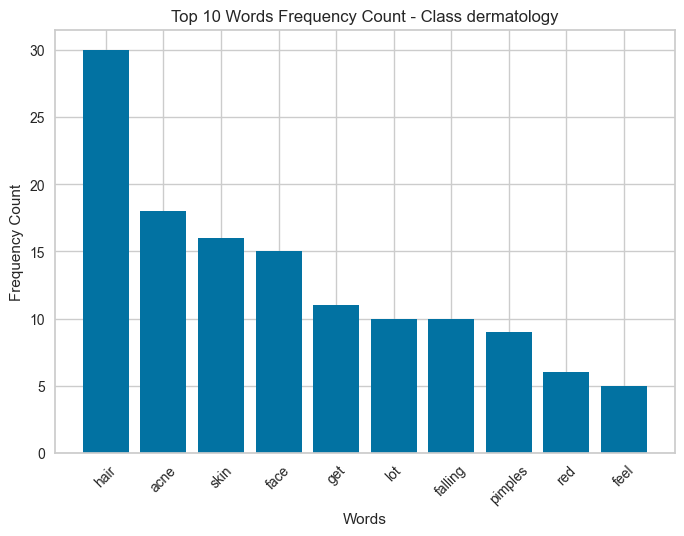

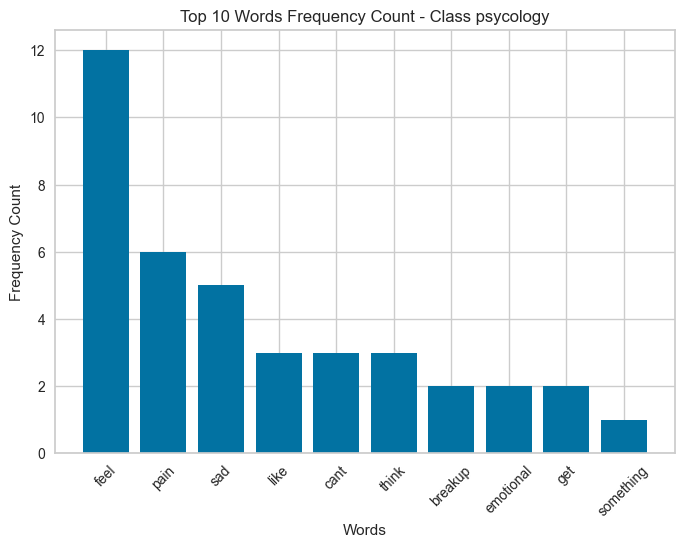

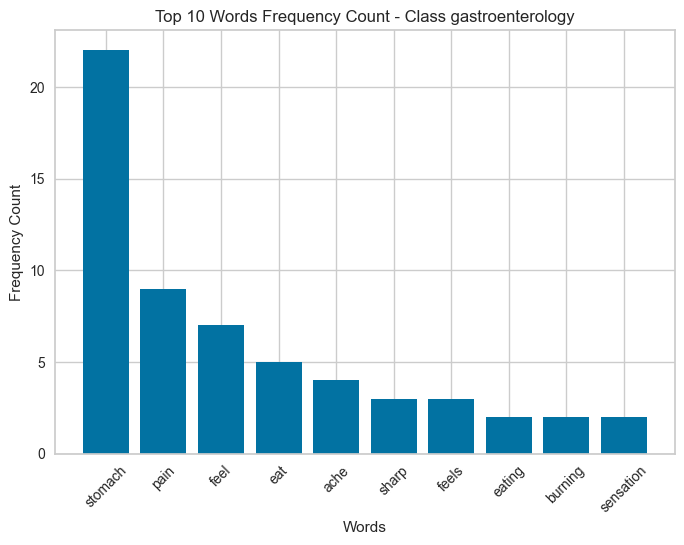

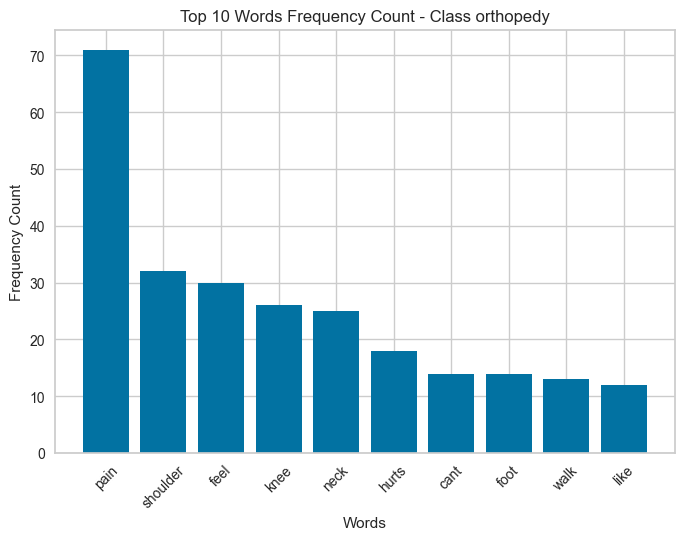

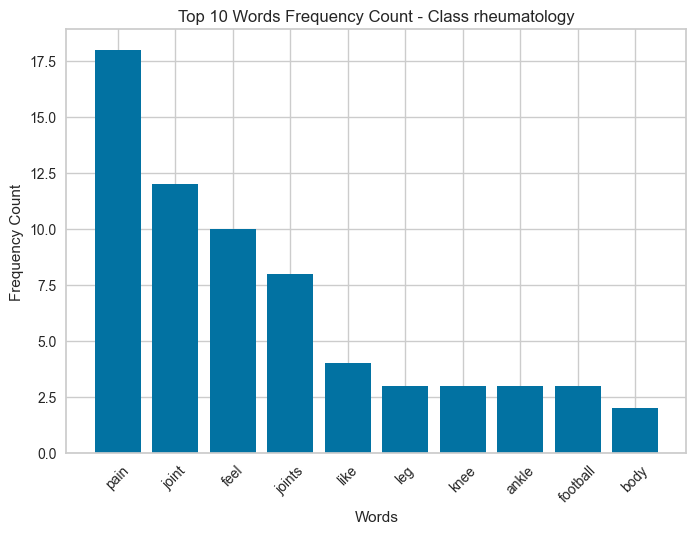

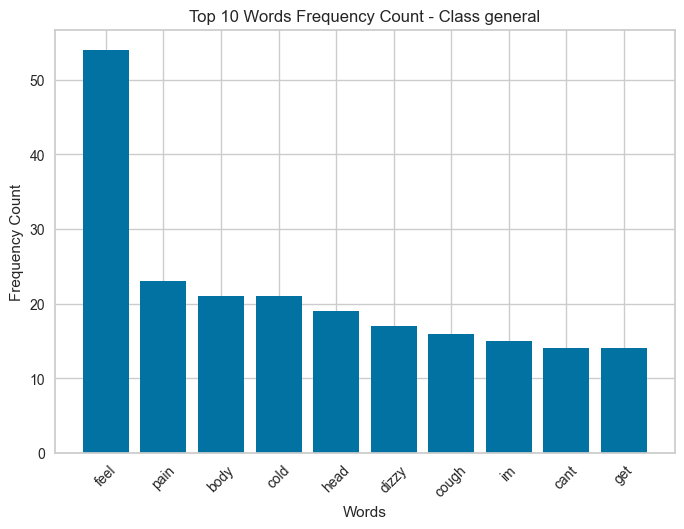

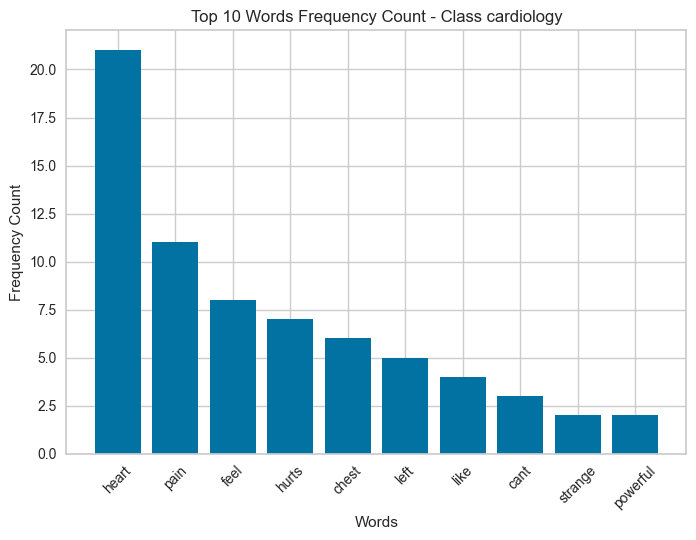

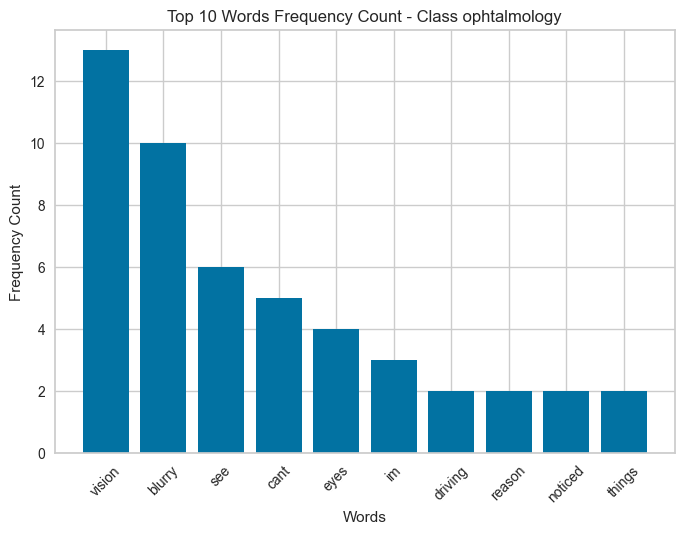

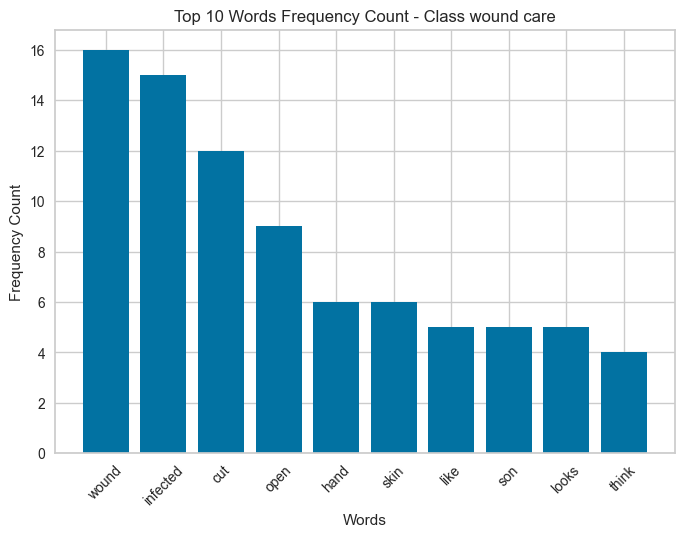

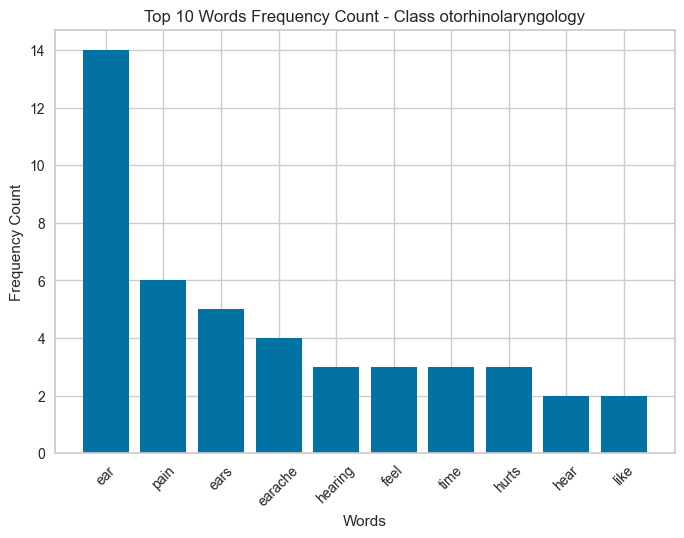

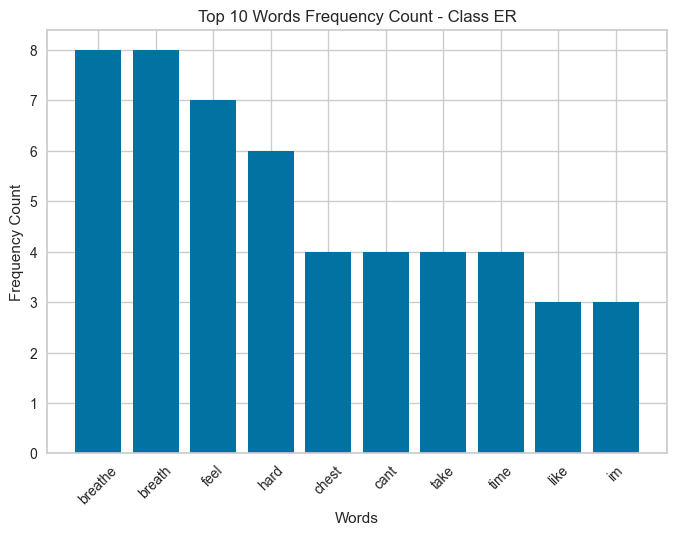

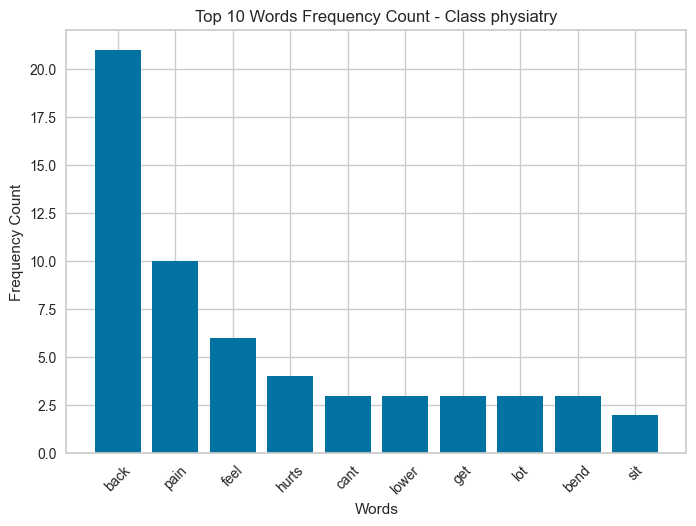

In [676]:
# identify top 10 words in each category

# Remove stopwords
stopwords_set = set(stopwords.words('english'))
df_test['phrease_copy']  = df_test['text_clean_extra_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))


word_counts = Counter(' '.join(df_test['phrease_copy']).split())
top_20_words = dict(word_counts.most_common(20))
print(top_20_words)

# Calculate frequency count of words per class
class_counts = {}
for cls in df_test['prompt'].unique():
    filtered_sentences = ' '.join(df_test[df_test['prompt'] == cls]['phrease_copy'])
    word_counts = Counter(filtered_sentences.split())
    class_counts[cls] = dict(word_counts.most_common(10))

# Visualize the results for each class
for cls, word_counts in class_counts.items():
    plt.bar(word_counts.keys(), word_counts.values())
    plt.xlabel('Words')
    plt.ylabel('Frequency Count')
    plt.title(f'Top 10 Words Frequency Count - Class {cls}')
    plt.xticks(rotation=45)
    plt.show()


In [677]:
# visalize the most common words per class by a sunburst plot


#import libraries and download the required NLTK resources
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


# preprocess the text by removing stopwords and filtering out nouns
def preprocess_text(text):
    stopwords_set = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns = [word for word, tag in pos_tags if tag.startswith('NN') and word.lower() not in stopwords_set]
    return nouns


# Group the data by the "prompt" column and apply preprocessing_text to "text" column:
grouped_data = df_test.groupby('prompt')['phrease_copy'].apply(lambda x: ' '.join(x)).reset_index()
grouped_data['nouns'] = grouped_data['phrease_copy'].apply(preprocess_text)

# Count frequency of unique nouns for each prompt and select top 10 nouns by frequency
class_noun_counts = grouped_data.explode('nouns').groupby('prompt')['nouns'].value_counts().reset_index(name='count')
top_nouns = class_noun_counts.groupby('prompt').head(10)

# Plot the Sunburst graph
fig = px.sunburst(top_nouns, path=['prompt', 'nouns'], values='count', color='count',
                  color_continuous_scale='reds', title='Top 10 nouns by domain',
                  maxdepth=-1, branchvalues='total',
                  width=750, height=750)

fig.update_traces(textfont=dict(size=14))
fig.show()




[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


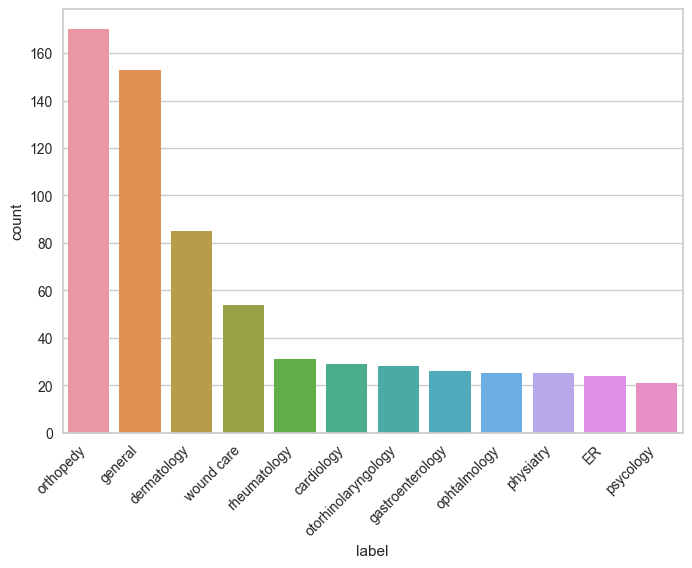

In [678]:
# Model 2: classifying the ailments by 'prompt'
label = pd.Series(df_test['prompt']).value_counts().index
count = pd.Series(df_test['prompt']).value_counts().values
data = {
    'label': label,
    'count': count
}
data = pd.DataFrame(data)
sns.barplot(data = data , x ='label', y='count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [681]:
df_test.to_csv("df_test_used_for_building_Model1.csv")

In [707]:
from fastai.text.data import TextList

np.random.seed(7)
path = '/Users/admin/Documents/BC#2/Labs/Week10/speech-recognition/'
data_clas = (TextList.from_csv(path, 'df_test_used_for_building_Model1.csv', cols='text_clean')
                   .random_split_by_pct(.2)
                   .label_from_df(cols='prompt')
                   .databunch(bs=42))
MODEL_PATH = "/tmp/model/"
learn = text_classifier_learner(data_clas, model_dir=MODEL_PATH, arch=AWD_LSTM)
learn.fit_one_cycle(5)




ImportError: cannot import name 'TextList' from 'fastai.text.data' (/Users/admin/opt/anaconda3/lib/python3.9/site-packages/fastai/text/data.py)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [705]:
pip install fastai==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement torch<0.4 (from fastai) (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch<0.4
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install fastai
#pip install scispacy
#pip install pysoundfile
!apt-get install libav-tools -y
!apt-get install zip
!pip freeze > '../working/dockerimage_snapshot.txt'

In [706]:
from fastai.text import *
from fastai.vision import *
import spacy
from spacy import displacy
import scispacy
import librosa
import librosa.display

In [694]:

import soundfile as sf
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import IPython

from glob import glob


import pylab
import gc

In [679]:
# building the model

# Split dataset
X = df_test['text_clean_extra_clean']
y = df_test['prompt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [680]:
# Feature engineering: TF-IDF Vectors as features
tfidfconverter = TfidfVectorizer(max_features=10)
X_train_Tfidf_df = tfidfconverter.fit_transform(X_train).toarray()
X_train_Tfidf_df = pd.DataFrame(X_train_Tfidf_df)
X_test_Tfidf_df = tfidfconverter.transform(X_test).toarray()
X_test_Tfidf_df = pd.DataFrame(X_test_Tfidf_df)
X_train_Tfidf_df

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.472587,0.256855,0.000000,0.469096,0.530497,0.457395
1,0.000000,0.000000,0.000000,0.000000,0.878613,0.477534,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.878613,0.477534,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.682033,0.000000,0.617971,0.000000,0.391079,0.000000,0.000000,0.000000,0.000000
4,0.569956,0.000000,0.507423,0.000000,0.567827,0.308619,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
531,0.000000,0.705893,0.000000,0.000000,0.000000,0.000000,0.708319,0.000000,0.000000,0.000000
532,0.000000,0.000000,0.854384,0.000000,0.000000,0.519643,0.000000,0.000000,0.000000,0.000000
533,0.000000,0.000000,0.000000,0.845006,0.000000,0.534756,0.000000,0.000000,0.000000,0.000000
534,0.575641,0.000000,0.000000,0.492535,0.573491,0.311697,0.000000,0.000000,0.000000,0.000000


In [348]:
# Test several classifiers
classifiers = [
    LogisticRegression(max_iter = 1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_jobs = -1),
    SVC(),
    GaussianNB(),
    KNeighborsClassifier(n_jobs = -1)
]

for classifier in classifiers:
    pipe = make_pipeline(classifier)
    grid = GridSearchCV(estimator = pipe, param_grid = {}, cv = 5, scoring = "recall")
    grid.fit(X_train_Tfidf_df, y_train)
    
    print(f"Train score for {classifier}: {grid.best_score_}")
    print("")

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

Train score for LogisticRegression(max_iter=1000): nan

Train score for DecisionTreeClassifier(): nan



/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

Train score for RandomForestClassifier(n_jobs=-1): nan



/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

Train score for SVC(): nan

Train score for GaussianNB(): nan

Train score for KNeighborsClassifier(n_jobs=-1): nan



/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

In [ ]:
### Summary

In [ ]:
For the second model: 


## explore  fastai.text_classifier_learner() functions to categorize the text descriptions according to the ailment category

https://www.kaggle.com/code/paultimothymooney/medical-symptoms-text-and-audio-classification/notebook
 

# Extracting audio features

In [178]:
from pydub import AudioSegment

In [69]:
# Load files
audio_segment = AudioSegment.from_file("/Users/admin/Documents/BC#2/Labs/Week10/speech-recognition/1249120_44246595_76562955.wav")

In [70]:
# Print attributes
print(f"Channels: {audio_segment.channels}")
print(f"Sample width: {audio_segment.sample_width}")
print(f"Frame rate (sample rate): {audio_segment.frame_rate}")
print(f"Frame width: {audio_segment.frame_width}")
print(f"Length (ms): {len(audio_segment)}")
print(f"Frame count: {audio_segment.frame_count()}")
print(f"Intensity: {audio_segment.dBFS}")

Channels: 2
Sample width: 2
Frame rate (sample rate): 44100
Frame width: 4
Length (ms): 3344
Frame count: 147456.0
Intensity: -33.93129040731416


# Quality of the audio
import librosa
import librosa.display
import matplotlib.pyplot as plt

x, fs = librosa.load("/Users/admin/Documents/BC#2/Labs/Week10/speech-recognition/1249120_44246595_76562955.wav")

zcrs = librosa.feature.zero_crossing_rate(x + 0.0001)
plt.figure(figsize=(18, 5))
plt.plot(zcrs[0])
plt.title('ZCR')

plt.show()
